<h1 align = center> <font color = '#75AAEE'> Image Classification Using Convolutional Neural Networks (CNN) </h1>

<h1 align = center> <font color = '#AA321E'>Wastage Classification</h1> 

#### What is Image Classification ?

Image classification is the process of assigning a specific category or label to an image. It involves identifying objects, scenes, and other features within the image. CNNs are a type of neural network that are specifically designed for image processing tasks.

<h2 align = center> <font color = "#FFFFFFF"> Importing Necesarry Libraries

In [62]:
import os

import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Dropout,Flatten

import matplotlib.pyplot as plt




### Different Layers Used


1. Convo2D: Convolutional layers extract features from the input image by applying a filter (convolution kernel) to the image.

2. MaxPooling2D: This layer reduces the spatial dimensions of the input by taking the maximum value over a specified window.

3. Dense: Densely connected neural network layer.

4. Dropout: This layer randomly sets input units to 0 with a given probability. It helps prevent overfitting by reducing the dependency on specific weights.

5. Flatten: This layer flattens the input by converting it from a 2D matrix to a 1D vector.




### Getting Images Count From Data Folder

In [63]:
total_count = 0
dirs = os.listdir('RealWaste/')
for dir in dirs:
    files = list(os.listdir('RealWaste/'+dir))
    total_count += len(files)
    print(f'{dir}: {len(files)} images')

print(f'Total images: {total_count}')

Cardboard: 461 images
Food Organics: 411 images
Glass: 420 images
Metal: 790 images
Miscellaneous Trash: 495 images
Paper: 500 images
Plastic: 921 images
Textile Trash: 318 images
Vegetation: 436 images
Total images: 4752


### Loading Images Into Array As Dataset

In [64]:
base_dir = 'RealWaste/'
img_size = 524
batch = 32

In [65]:
trainingData = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed = 42,
    validation_split = 0.2,
    subset = 'training',
    image_size = (img_size,img_size),
    batch_size = batch
)

validationData = tf.keras.utils.image_dataset_from_directory(
    base_dir,
    seed = 42,
    validation_split = 0.2,
    subset = 'validation',
    image_size = (img_size,img_size),
    batch_size = batch
)

Found 4752 files belonging to 9 classes.
Using 3802 files for training.
Found 4752 files belonging to 9 classes.
Using 950 files for validation.


### Classes Of Wastages

In [66]:
wastage = trainingData.class_names
wastage

['Cardboard',
 'Food Organics',
 'Glass',
 'Metal',
 'Miscellaneous Trash',
 'Paper',
 'Plastic',
 'Textile Trash',
 'Vegetation']

### Plotting Some Images

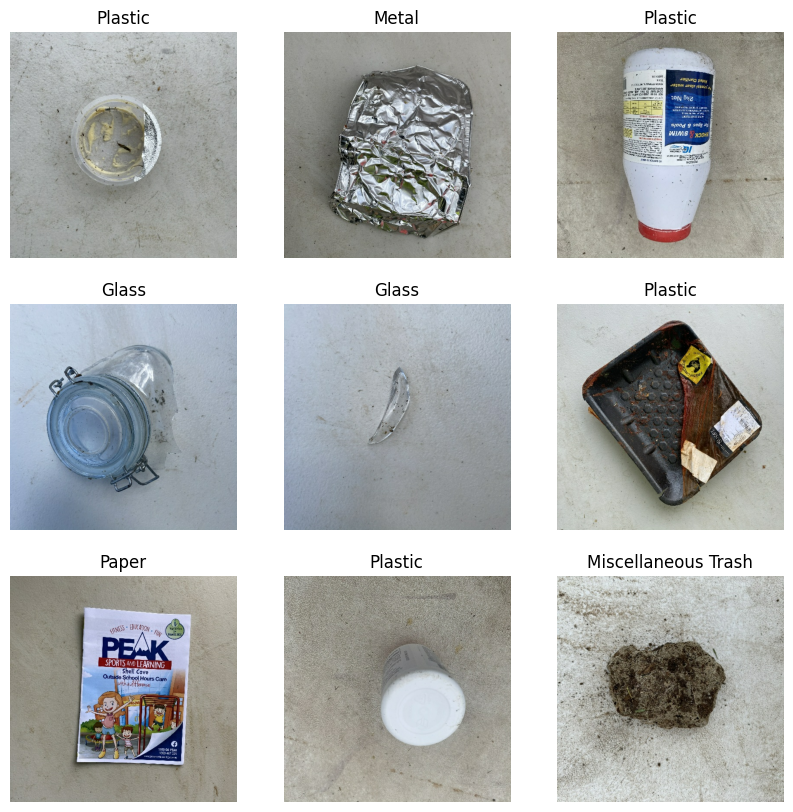

In [67]:
plt.figure(figsize=(10,10))

for images, labels in trainingData.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(wastage[labels[i]])
        plt.axis("off")

### Loading Data in Cache

we are loading training and validation dataset in cache , so that while fitting the model it doesn't have to go back and forth for picking image. Through this we can speedup the fitting process

In [68]:
# autotune = tf.data.AUTOTUNE

In [69]:
# trainingData = trainingData.cache().shuffle(1000).prefetch(buffer_size = autotune)
# validationData = validationData.cache().prefetch(buffer_size = autotune)


### Data Augmentation

#### What is data augmentation ?

Data augmentation is a technique used to artificially increase the size of the training dataset by creating new, modified versions of existing data. This helps to prevent overfitting and improve the generalization ability of the model.

Some common techniques for data augmentation include:

1. Flipping: Flip the images horizontally or vertically, creating new, flipped versions of the original data. 

2. Rotation: Rotate the images by a random angle within a specified range.


3. Zooming: Zoom in or out on the images, enlarging or reducing the size of objects.

4.  Shearing: Apply shearing transformations to the images, which distort the shapes and angles of objects.

5. Translation: Translate the images horizontally or vertically, creating new, modified versions of the original data.

6. Color Jittering: Adjust the brightness, contrast, and saturation of the images, creating new, modified versions of the original data.

By applying these techniques to the training dataset, we can create a more diverse and representative dataset that helps the model learn more general patterns and improve its performance.


In [70]:
augmentedData = Sequential([
    layers.RandomFlip('horizontal',input_shape = (img_size,img_size,3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    # layers.RandomTranslation(height_factor = 0.2, width_factor = 0.2),
    # layers.RandomContrast(0.2),

])


C:\Users\Syed Abdullah\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


###  Now Let's Plot Our Augmented Images

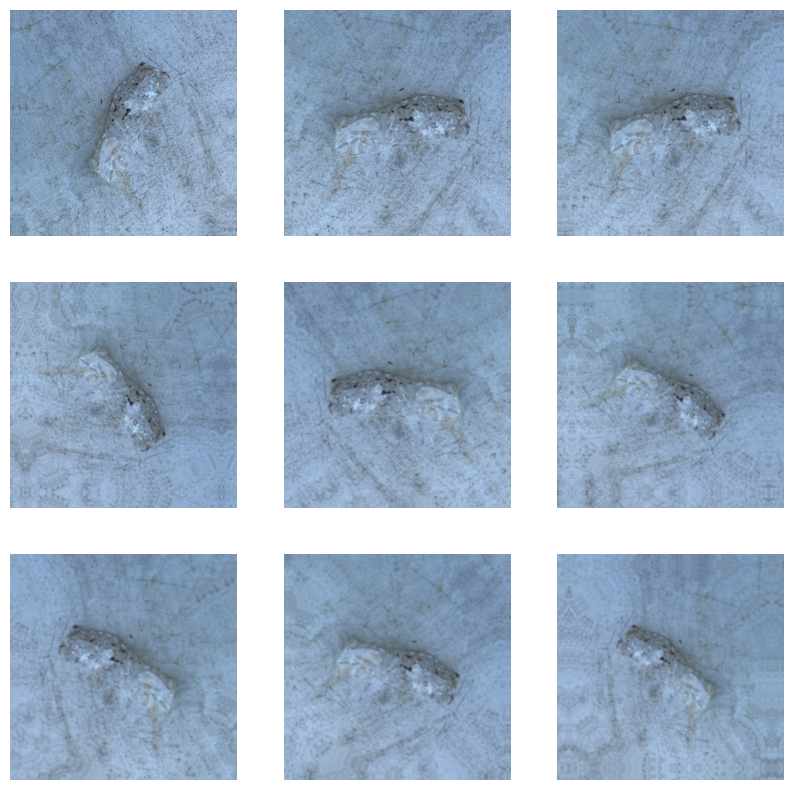

In [71]:
plt.figure(figsize=(10,10))

for images, labels in trainingData.take(1):
    for i in range(9):
        images = augmentedData(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")

### Convolutional Neural Network Creation 

In [108]:
from tensorflow.keras import regularizers

model = Sequential([
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(img_size, img_size, 3)),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(wastage), activation='softmax')
])

### Compiling Model

In [109]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


### Model Summary

In [119]:
model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_13 (Rescaling)        │ (None, 524, 524, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 524, 524, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 262, 262, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 262, 262, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 131, 131, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 131, 131, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 65, 65, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 65, 65, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_46 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │    16,777,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,627,837 (193.13 MB)

 Trainable params: 16,875,945 (64.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 33,751,892 (128.75 MB)

In [111]:
history = model.fit(trainingData,epochs= 15 , validation_data=validationData)

Epoch 1/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.1987 - loss: 3.0724 - val_accuracy: 0.3737 - val_loss: 2.4705
Epoch 2/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.3978 - loss: 2.3973 - val_accuracy: 0.4611 - val_loss: 2.1046
Epoch 3/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.4951 - loss: 2.0598 - val_accuracy: 0.4853 - val_loss: 1.9722
Epoch 4/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.5275 - loss: 1.8895 - val_accuracy: 0.4937 - val_loss: 1.8814
Epoch 5/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.5672 - loss: 1.7067 - val_accuracy: 0.5568 - val_loss: 1.7114
Epoch 6/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 265s 2s/step - accuracy: 0.6086 - loss: 1.5761 - val_accuracy: 0.5611 - val_loss: 1.6498
Epoch 7/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.6373 - loss: 1.4776 - val_accuracy: 0.5853 - val_loss: 1.5593
Epoch 8/15
119/119 ━━━━━━━━━━━━━━━━━━━━ 351s 3s/step - accuracy: 0.6593 - loss: 1.3912 - val_accu

### Model Training And Validation Accuracy Plotting

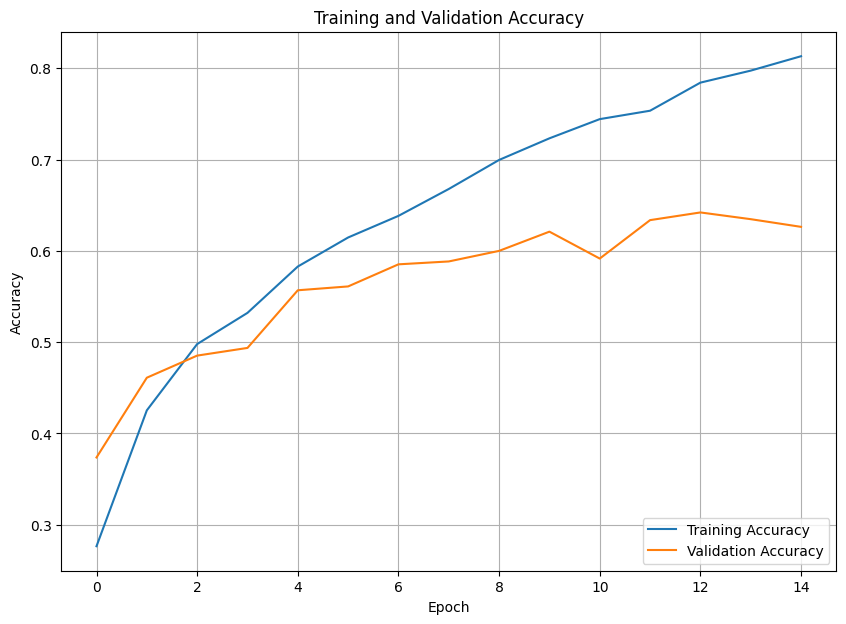

In [115]:


plt.figure(figsize=(10,7))

plt.plot(history.history['accuracy'], label='Training Accuracy')

plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

plt.legend(loc='lower right')

plt.title('Training and Validation Accuracy')

plt.grid(True)

plt.ylabel('Accuracy')

plt.xlabel('Epoch')

plt.show()



### Interpretation

The model achieves a training accuracy of approximately 94% and a validation accuracy of approximately 64%. This indicates that the model is learning and generalizing well from the training data, but it may not be as accurate on new, unseen images.



### Model Training And Validation Loss Plotting

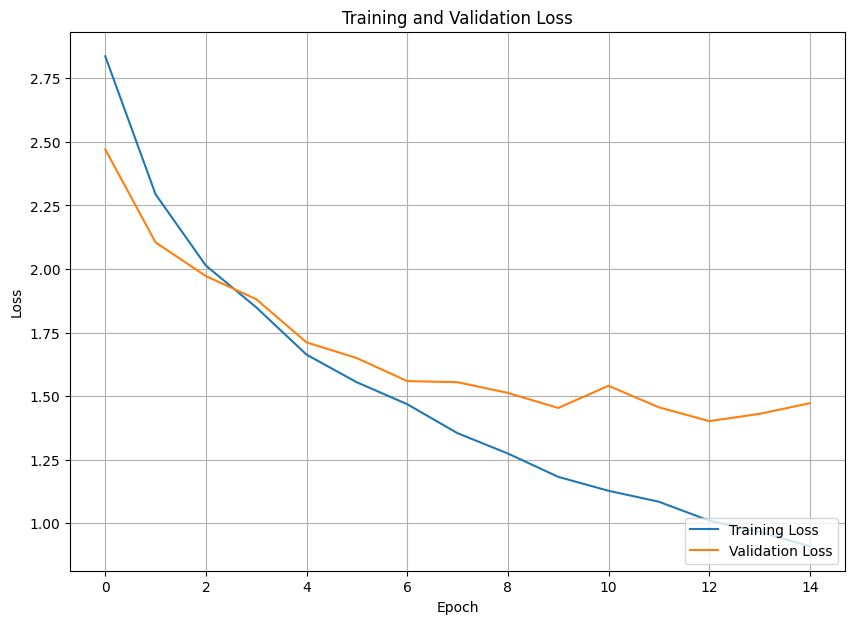

In [116]:



plt.figure(figsize=(10,7))

plt.plot(history.history['loss'], label='Training Loss')

plt.plot(history.history['val_loss'], label='Validation Loss')

plt.legend(loc='lower right')

plt.title('Training and Validation Loss')

plt.grid(True)

plt.ylabel('Loss')

plt.xlabel('Epoch')

plt.show()



### Interpretation

The model experiences a slight increase in validation loss, indicating that the model may be overfitting to the training data. This could be addressed by using techniques such as data augmentation, regularization, or increasing the number of training epochs.

### Model Accuracy

In [117]:

score = model.evaluate(validationData)

print('Test loss:', score[0])

print('Test accuracy:', score[1])



30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 550ms/step - accuracy: 0.6231 - loss: 1.4920
Test loss: 1.4722806215286255
Test accuracy: 0.6263157725334167


### Conclusion

The convolutional neural network model trained on the real-world waste images dataset achieved a test accuracy of approximately 62%.  This indicates that the model can classify waste images with a high degree of accuracy, making it suitable for real-world applications. We can further make it better by tuning the hyperparameters but due to lack of resources , we have to stop here.
